In [5]:
import os
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import re
import seaborn as sns
from pandas import isnull

In [2]:

def read_sparse_matrix(file):
    """
    reads in matrix via non-zero entry triples
    ex input:
    size: 3
    (0,0,123) (1,1,5) (2,1,-23)
    
    should output a matrix like:
    np.array([
        [123, 0,   0],
        [0,   5,   0],
        [0,   -23, 0]
    ])
    """
    m_size = int(file.readline().split()[1])
    m = np.zeros((m_size, m_size))
    for nnz_triple_str in file.readline().split():
        i, j, val = nnz_triple_str[1:-1].split(',')
        i = int(i)
        j = int(j)
        val = float(val)
        m[i,j] = val
    return m

def read_square_matrix(file):
    """
    function that reads in a square matrix from the file if the matrix is printed element by element separated by whitespace like:
    1 0 0
    2 1 0
    3 2 1
    """
    m = []
    cur_row = 1
    max_rows = 1    # placeholder value... since max_rows == # cols, we update this value in the loop
    while cur_row <= max_rows:
        line = file.readline()
        data = [float(x) for x in line.split()]
        m.append(data)
        if cur_row == 1:
            max_rows = len(data)    # number of rows = number of columns
        cur_row += 1
    return m


def read_data(f_path):
    data = {
        # 'N': [],
        'Q': [],
        # 'M': [],
        'policy_converged': [],
        # 'penalty_converged': []
        'f_name':[]
    }
    with open(f_path) as f:
        while True:
            line = f.readline()
            if not line:
                data['f_name'] = [f_path] * len(data['Q'])
                return data
            # if re.match("^N", line):
            #     data['N'].append(
            #         # np.array(read_square_matrix(f))
            #         read_sparse_matrix(f)
            #     )
            if re.match("^Q", line):
                data['Q'].append(
                    # np.array(read_square_matrix(f))
                    read_sparse_matrix(f)
                )
            # if re.match("^M", line):
            #     data['M'].append(
            #         # np.array(read_square_matrix(f))
            #         read_sparse_matrix(f)
            #     )
            if re.match("^policy_converges", line):
                data['policy_converged'].append(
                    bool(int(f.readline()))
                )
            # if re.match("^penalty_converges", line):
            #     data['penalty_converged'].append(
            #         bool(int(f.readline()))
            #     )

In [9]:
assets_dir = '/home/isaiah/scisim/assets/rigidbody2d/isaiah_ura/'
# loading the data from the files
data_outs = [
    '1000a.out','1000b.out','1000c.out','1000d.out','1000za.out','1000zb.out'
]
#  + [ f"outs/grid/itr_{x}.xml.out" for x in range(100) ]
data = {
    'Q':[],
    'policy_converged':[],
    'f_name':[]
}

for f_name in data_outs:
    temp_data = read_data(assets_dir + f_name)
    data['Q'] += temp_data['Q'].copy()
    data['policy_converged'] += temp_data['policy_converged'].copy()
    data['f_name'] += temp_data['f_name'].copy()
pd_data = pd.DataFrame(data)

FileNotFoundError: [Errno 2] No such file or directory: '1000a.out'

In [ ]:
sizes = [x.shape[0] for x in pd_data['Q']]
sum(sizes)

110884

In [ ]:
# doing some calculations on the data
def inverse_with_default(x, default):
    try:
        return np.linalg.inv(x)
    except:
        return default
def min_val_with_default(x, default):
    try:
        return np.amin(x)
    except:
        return default
def lt_0_with_default(x, default):
    try:
        return np.count_nonzero(x < 0)
    except:
        return default

print("size...")
Q_size = [x.shape[0] for x in pd_data['Q']]
print("inverse calculations...")
Q_inv = [inverse_with_default(x, None) for x in pd_data['Q']]
Q_inv_min_val = [min_val_with_default(x, None) for x in Q_inv]
Q_inv_num_lt_0 = [lt_0_with_default(x, None) for x in Q_inv]
print("eigenvalues...")
eigenvalues = [np.linalg.eig(x)[0] for x in pd_data['Q']]
print("condition numbers...")
cond_num = [np.linalg.cond(x) for x in pd_data['Q']]

# many of the columns are just a scaled colum from the identity matrix (i.e.
# all rows of col i are 0 except for row i). We care about the interesting columns...
# i.e. those with more than 1 non-zero
print("off-diags...")
Q_num_off_diag_entries = [(np.count_nonzero(x) - np.shape(x)[0]) for x in pd_data['Q']]

# angles...
print("angles...")
thetas = []
min_theta = []
for x in pd_data['Q']:
    new_thetas = []
    for row in range(x.shape[0]):
        for col in range(x.shape[1]):
            val = x[row,col]
            if col == row or val == 0:
                continue
            m_inv_scaling_factor = x[col,col] / 2
            # if cos_theta is < -1 or > 1, then im pretty sure this element corresponds to a wall-ball collision
            # we don't really care about that case
            cos_theta = val / m_inv_scaling_factor
            if -1 > cos_theta or 1 < cos_theta:
                continue
            new_thetas.append(math.acos(cos_theta) * 180 / math.pi)
    thetas.append(new_thetas.copy())
    min_theta.append(min(new_thetas + [math.inf]))

print("stitching it all together...")

computed_data = pd_data.copy()
computed_data['Q_size'] = Q_size
computed_data['Q_inv'] = Q_inv
computed_data['Q_inv_min_val'] = Q_inv_min_val
computed_data['Q_inv_num_lt_0'] = Q_inv_num_lt_0
computed_data['eigenvalues'] = eigenvalues
computed_data['cond_num'] = cond_num
computed_data['Q_num_off_diag_entries'] = Q_num_off_diag_entries
computed_data['thetas'] = thetas
computed_data['min_theta'] = min_theta

size...
inverse calculations...
eigenvalues...
condition numbers...
off-diags...
angles...
stitching it all together...


In [ ]:
# 10^18 is pretty close to infinity
computed_data['cond_num_no_inf'] = [min(10e18, x) for x in computed_data['cond_num']]


<AxesSubplot: xlabel='Q_size', ylabel='Q_inv_num_lt_0'>

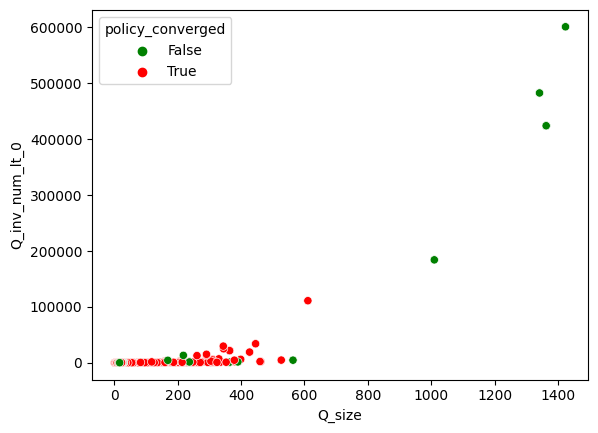

In [ ]:
# data visualization...
# number of negs in the inverse
sns.scatterplot(data=computed_data, x=computed_data.Q_size , y='Q_inv_num_lt_0', hue='policy_converged', palette=["green", "red"])


<AxesSubplot: xlabel='Q_size', ylabel='Q_inv_num_lt_0'>

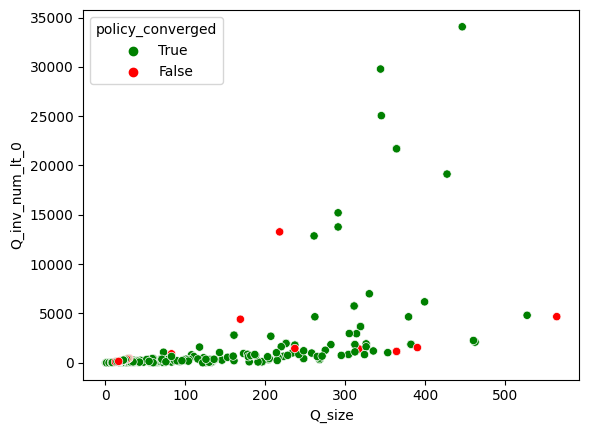

In [ ]:
sns.scatterplot(data=computed_data[computed_data.Q_size < 600], x=computed_data.Q_size , y='Q_inv_num_lt_0', hue='policy_converged', palette=["green", "red"])
# inconclusive... seems when Q is small the # of negative entires doesn't seem to matter too much

<AxesSubplot: ylabel='min_theta'>

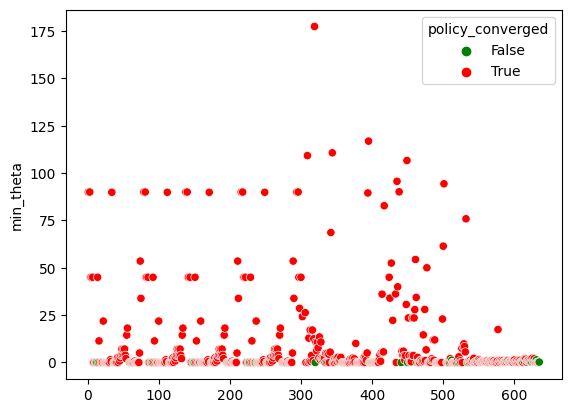

In [ ]:
# min angle
max_angle = 180
# sns.scatterplot(data=computed_data, x=computed_data.index, y='min_theta', hue='policy_converged', palette=["green", "red"])
# sns.scatterplot(data=computed_data[computed_data.min_theta < 25], x=computed_data[computed_data.min_theta < 25].index, y='min_theta', hue='policy_converged', palette=["green", "red"])
sns.scatterplot(data=computed_data[computed_data.min_theta < max_angle], x=computed_data[computed_data.min_theta < max_angle].index, y='min_theta', hue='policy_converged', palette=["green", "red"])


<AxesSubplot: >

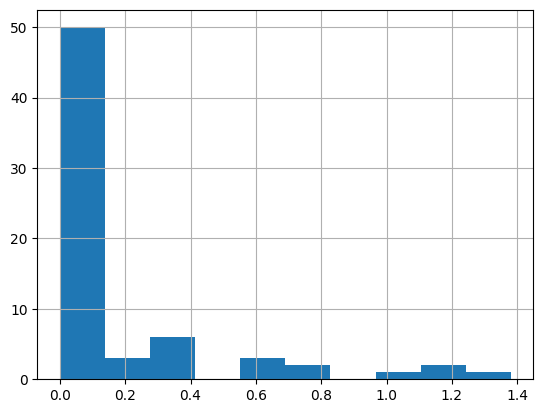

In [ ]:
# what does the distribution of MIN angles look like in the non-converging cases?
computed_data[computed_data.policy_converged == False].min_theta.hist()

/tmp/ipykernel_4875/750275894.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  computed_data[computed_data.policy_converged == True][computed_data.min_theta < 360].min_theta.hist(bins=30)


<AxesSubplot: >

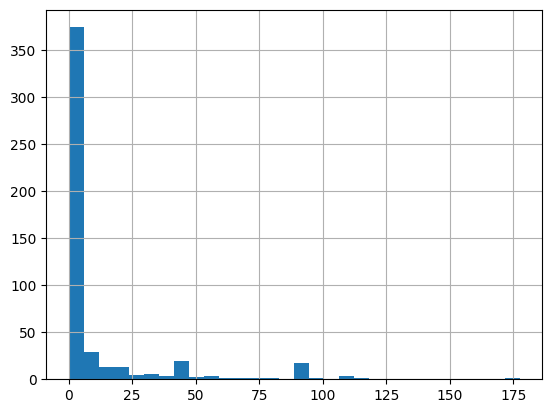

In [ ]:
# what does the distribution of MIN angles look like in the non-converging cases?
computed_data[computed_data.policy_converged == True][computed_data.min_theta < 360].min_theta.hist(bins=30)
# computed_data[computed_data.min_theta < 360].min_theta.hist()

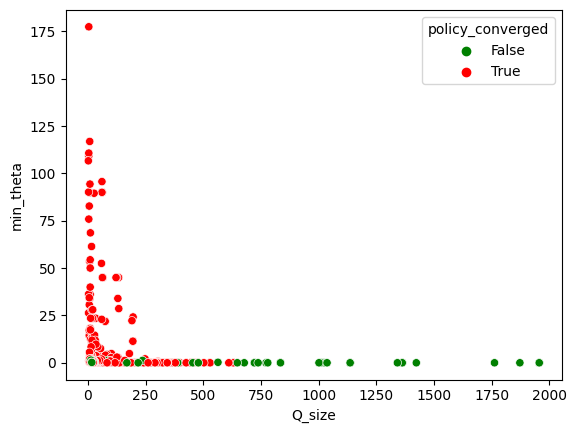

In [ ]:
splot = sns.scatterplot(
    data=computed_data[computed_data.min_theta < 360],
    x=computed_data[computed_data.min_theta < 360].Q_size,
    y='min_theta',
    hue='policy_converged',
    palette=["green", "red"]
)


<AxesSubplot: >

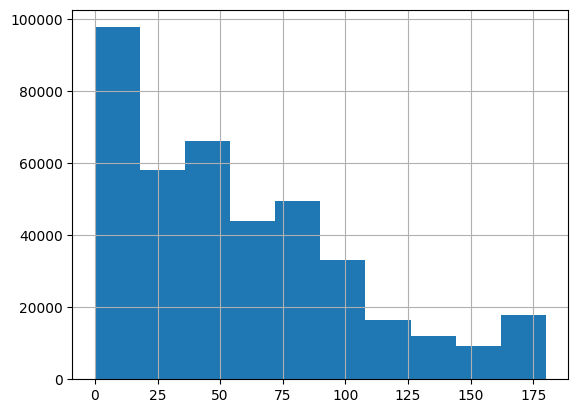

In [ ]:
# what does the distribution of ALL angles look like in the non-converging cases?
computed_data[computed_data.policy_converged == False].thetas.explode().hist()

<AxesSubplot: >

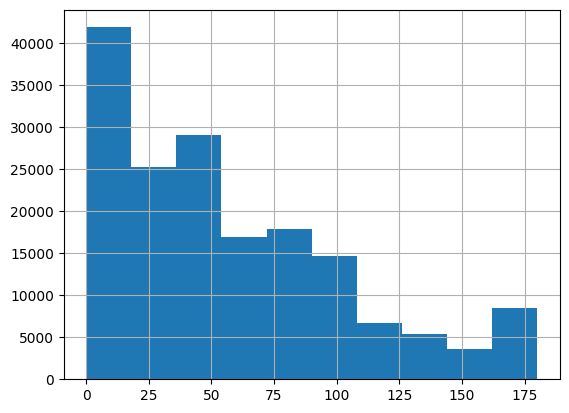

In [ ]:
# what does the distribution of ALL angles look like in the converging cases?
computed_data[computed_data.policy_converged == True].thetas.explode().hist()

In [ ]:
# condition numbers
# print(len(computed_data[computed_data.cond_num == math.inf])) # 24 with an infinite condition number
# print(len(computed_data[computed_data.cond_num != math.inf])) # 512 with condition number in the reals
# scale is way to big to be usefule
# computed_data[computed_data.cond_num != math.inf].cond_num.hist()
computed_data.cond_num.describe()


count    6.360000e+02
mean              inf
std               NaN
min      1.000000e+00
25%      7.010279e+00
50%      2.850068e+04
75%      4.787505e+07
max               inf
Name: cond_num, dtype: float64

In [ ]:
# condition numbers of non-converging cases
computed_data[computed_data.policy_converged == False].cond_num.describe()

count    6.800000e+01
mean              inf
std               NaN
min      3.262322e+04
25%      1.039858e+08
50%      2.072336e+18
75%      2.470587e+19
max               inf
Name: cond_num, dtype: float64

In [ ]:
# condition numbers of converging cases
computed_data[computed_data.policy_converged == True].cond_num.describe()

# takeaway: MUCH higher condition numbers for non-converging case

count    5.680000e+02
mean              inf
std               NaN
min      1.000000e+00
25%      5.007103e+00
50%      2.138212e+02
75%      2.525931e+07
max               inf
Name: cond_num, dtype: float64

[None]

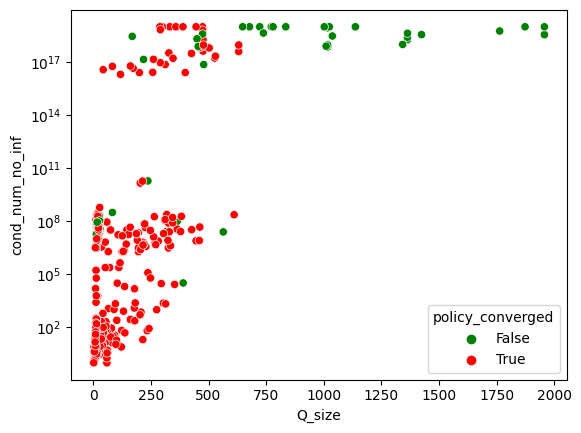

In [ ]:
# qsize vs cond number
splot = sns.scatterplot(
    data=computed_data,
    x=computed_data.Q_size,
    y='cond_num_no_inf',
    hue='policy_converged',
    palette=["green", "red"]
)
splot.set(yscale = 'log')

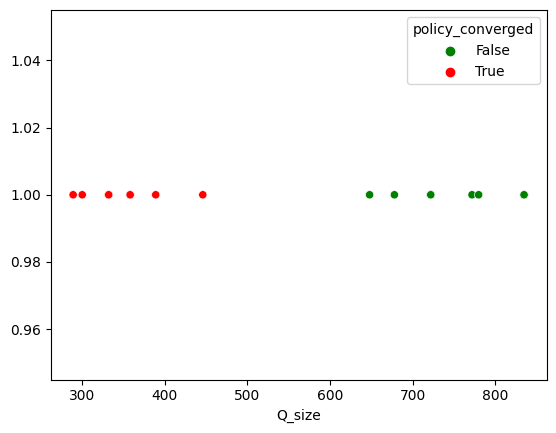

In [ ]:
# qsize vs cond number (only infinite case)
max_val = math.inf
splot = sns.scatterplot(
    data=computed_data[computed_data.cond_num == max_val],
    x=computed_data[computed_data.cond_num == max_val].Q_size,
    y=1,
    hue='policy_converged',
    palette=["green", "red"]
)

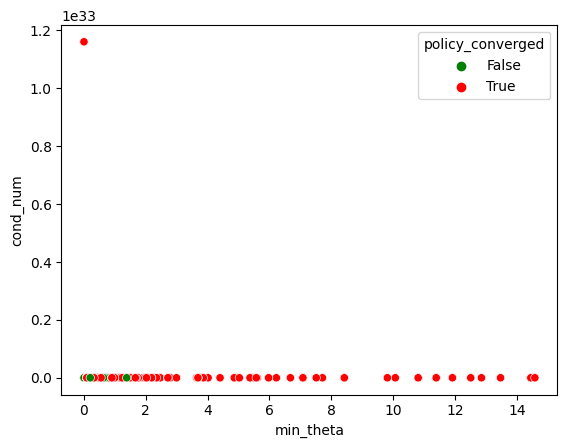

In [ ]:
# is singularity related to min_angle?
splot = sns.scatterplot(
    data=computed_data[computed_data.min_theta < 17],
    x='min_theta',
    y='cond_num',
    hue='policy_converged',
    palette=["green", "red"]
)
# splot.set(yscale = 'log')

In [ ]:
# from pandas import isnull

# all numbers/output are for simulations outputted from 1000.xml
"""
# does Q being non-invertible have a big effect?
# P(non-converging|not invertible)
p_non_conv_gvn_non_invertible = \
    len(computed_data[isnull(computed_data.Q_inv)][computed_data.policy_converged == False]) / \
    len(computed_data[isnull(computed_data.Q_inv)])
print(p_non_conv_gvn_non_invertible)   # 0.49295

# P(non-converging)
p_non_conv = \
    len(computed_data[computed_data.policy_converged == False]) / \
    len(computed_data)
print(p_non_conv )   # 0.09701492537313433
"""


'\n# does Q being non-invertible have a big effect?\n# P(non-converging|not invertible)\np_non_conv_gvn_non_invertible =     len(computed_data[isnull(computed_data.Q_inv)][computed_data.policy_converged == False]) /     len(computed_data[isnull(computed_data.Q_inv)])\nprint(p_non_conv_gvn_non_invertible)   # 0.49295\n\n# P(non-converging)\np_non_conv =     len(computed_data[computed_data.policy_converged == False]) /     len(computed_data)\nprint(p_non_conv )   # 0.09701492537313433\n'

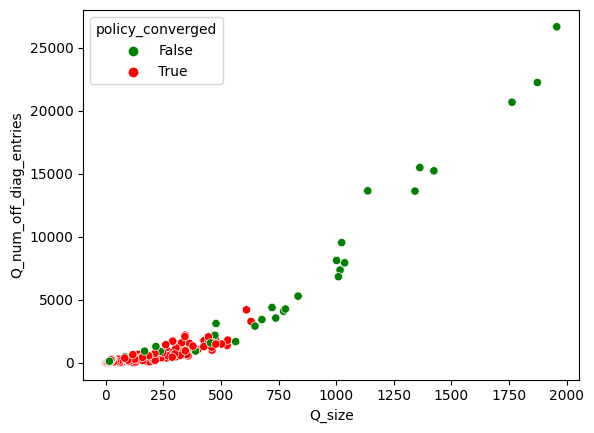

In [ ]:
splot = sns.scatterplot(
    data=computed_data,
    x=computed_data.Q_size,
    y='Q_num_off_diag_entries',
    hue='policy_converged',
    palette=["green", "red"]
)

# questions:
- why are we only investigating the properties of Q and not v0 (since b in the policy code is based off of the active set of constraints AND velocity)
- what is the policy iteration actually trying to solve?

# ideas for further investigation:
- there are some small (~size of 100) Qs that don't converge... I want to look specifically at them and see why
    - I want to see if orthogonal columns/rows can be dropped and still make policy diverge  
- one thing I noticed was the matrix was not 2 * Minv all the time on the diag... in ball-wall collisions this was half, would this have any effect?

# todo
- is singularity related to small angles
- rank if singular
- look at the geometry
- look at single case

/tmp/ipykernel_4875/3313798575.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b_heights, b_bins = np.histogram(computed_data[computed_data.cond_num < 10^13][computed_data.min_theta < 260]['min_theta'], bins=a_bins)


<BarContainer object of 10 artists>

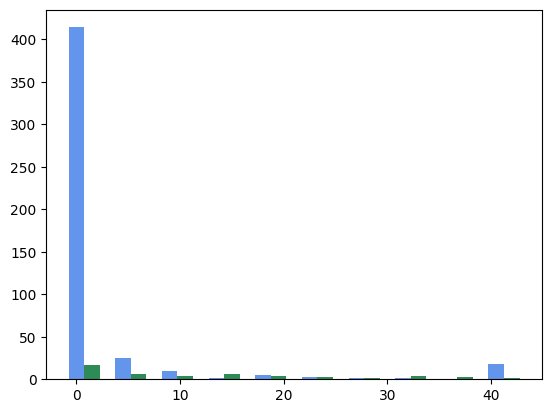

In [ ]:
# is the singularity related to small angles?
# here we assume anything with a condition number >10^13 is singular
# blue = min angle in singular case
# green = min angle in NON singular case

fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(computed_data[computed_data.cond_num >= 10^13]['min_theta'])
b_heights, b_bins = np.histogram(computed_data[computed_data.cond_num < 10^13][computed_data.min_theta < 260]['min_theta'], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')
#seaborn.despine(ax=ax, offset=10)

# plt.yscale('log')

In [ ]:
computed_data['rank'] = [np.linalg.matrix_rank(x) for x in computed_data.Q]

In [ ]:
computed_data[computed_data.cond_num > 10**13]['rank']

11      425
12      561
13      694
19     1000
23      979
       ... 
521     217
523     168
525     117
527      82
534    1643
Name: rank, Length: 92, dtype: int64

<BarContainer object of 10 artists>

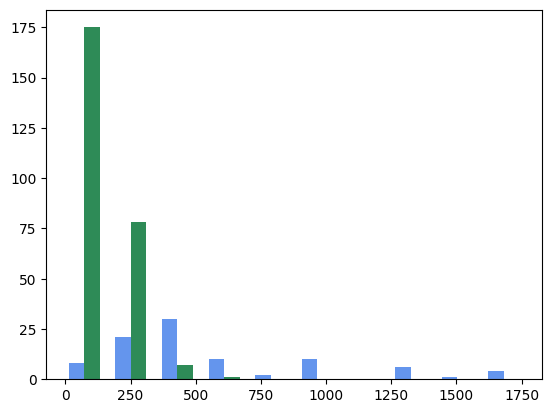

In [ ]:
# rank if singular

# here we assume anything with a condition number >10^13 is singular
# blue = rank in singular case
# green = rank in NON singular case

fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(
    computed_data[computed_data.cond_num > 10**13]['rank']
    , bins=10
)
b_heights, b_bins = np.histogram(
    computed_data[computed_data.cond_num <= 10**13]['rank']
    , bins=a_bins
    )

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')
#seaborn.despine(ax=ax, offset=10)

# plt.yscale('log')

[51, 161, 141, 137, 38, 40, 40, 35, 34, 125, 24, 25, 24, 24, 51, 161, 141, 137, 38, 40, 40, 35, 34, 51, 161, 141, 137, 38, 40, 40, 35, 34, 125, 24, 25, 24, 24, 51, 161, 141, 137, 38, 40, 40, 35, 34, 125, 24, 25, 24, 24, 52, 147, 135, 1, 1, 124, 37, 1, 31, 2, 31, 2, 2, 38, 32, 111, 1, 19, 19, 21, 19, 51, 147, 135, 126, 36, 29, 29, 2, 42, 31, 4, 2, 1, 1, 1, 1, 1, 1, 1, 120]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<BarContainer object of 10 artists>

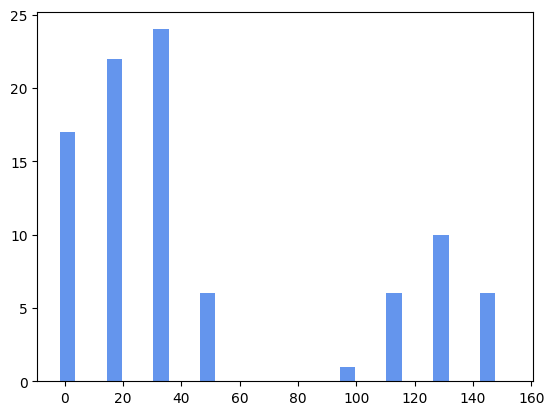

In [ ]:
# nullity if singular

# here we assume anything with a condition number >10^13 is singular
# blue = nullity in singular case
# green = nullity in NON singular case

fig, ax = plt.subplots()

singular_nullity = [
    computed_data['Q_size'][i] - computed_data['rank'][i]
    for i in computed_data[computed_data.cond_num > 10**13].index
]

non_singular_nullity = [
    computed_data['Q_size'][i] - computed_data['rank'][i]
    for i in computed_data[computed_data.cond_num <= 10**13].index
]

print(singular_nullity)
print(non_singular_nullity)

a_heights, a_bins = np.histogram(
    singular_nullity
    , bins=10
)
b_heights, b_bins = np.histogram(
    non_singular_nullity
    , bins=a_bins
    )

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')
#seaborn.despine(ax=ax, offset=10)

# plt.yscale('log')

In [ ]:
computed_data[computed_data.cond_num <= 10**13]

,Q,policy_converged,f_name,Q_size,Q_inv,Q_inv_min_val,Q_inv_num_lt_0,eigenvalues,cond_num,Q_num_off_diag_entries,thetas,min_theta,cond_num_no_inf,rank
0,"[[3.1438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",True,./1000a.out,62,"[[0.31808639226413893, 0.0, 0.0, 0.0, 0.0, 0.0...",0.000000e+00,0.0,"[3.1438, 3.1438, 3.1438, 3.1438, 3.1438, 3.143...",1.000000e+00,0,[],inf,1.000000e+00,62
1,"[[6.2876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",True,./1000a.out,62,"[[0.15904319613206946, 0.0, 0.0, 0.0, 0.0, 0.0...",-3.650764e-16,8.0,"[6.287599999999977, 6.2876, 6.28760000000003, ...",1.000000e+00,8,"[90.00000000000027, 89.99999999999974, 90.0000...",90.000000,1.000000e+00,62
2,"[[3.1438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",True,./1000a.out,62,"[[0.31808639226413893, 0.0, 0.0, 0.0, 0.0, 0.0...",0.000000e+00,0.0,"[3.1438, 3.1438, 3.1438, 3.1438, 3.1438, 3.143...",1.000000e+00,0,[],inf,1.000000e+00,62
3,"[[6.2876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",True,./1000a.out,62,"[[0.15904319613206946, 0.0, 0.0, 0.0, 0.0, 0.0...",-3.650764e-16,8.0,"[6.287599999999977, 6.2876, 6.28760000000003, ...",1.000000e+00,8,"[90.00000000000027, 89.99999999999974, 90.0000...",90.000000,1.000000e+00,62
4,"[[6.2876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",True,./1000a.out,126,"[[0.15904319613206946, 0.0, 0.0, 0.0, 0.0, 0.0...",-2.718933e+04,24.0,"[6.287599999999997, 3.1438000000000015, 12.575...",1.934143e+06,32,"[90.00000000000027, 89.99999999999973, 90.0000...",45.000059,1.934143e+06,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,"[[0.0795775, 0.0346393, 0.0, 0.0, 0.0, 0.0, 0....",False,outs/grid/itr_95.xml.out,13,"[[17.68155964719577, -11.751228022065147, 2.61...",-3.134195e+07,86.0,"[0.2223621743575918, 0.16172568431307244, 0.13...",1.831418e+07,76,"[29.473861320238708, 29.473861320238708, 27.32...",1.380572,1.831418e+07,13
632,"[[0.0795775, -0.000983458, 0.0282364, 0.039788...",True,outs/grid/itr_96.xml.out,23,"[[2230490.9264856693, 2162003.9842870184, -306...",-1.649937e+07,272.0,"[0.2992857654228993, 0.22183842791736133, 0.19...",3.274728e+07,216,"[91.41632325085405, 44.79291362431993, 0.09083...",0.090833,3.274728e+07,23
633,"[[0.0795775, -0.00143297, 0.0272588, 0.0397605...",True,outs/grid/itr_97.xml.out,23,"[[2303529.0720336805, 2360490.3399287877, -323...",-2.258411e+07,272.0,"[0.3104879660074459, 0.2474972588146753, 0.228...",4.172703e+07,228,"[92.06392239147299, 46.757462189573474, 2.1591...",0.090833,4.172703e+07,23
634,"[[0.0795775, 0.0373876, 0.0380697, 0.0, 0.0269...",True,outs/grid/itr_98.xml.out,15,"[[1992.1166922419707, -1083.142420988858, -970...",-1.177377e+07,112.0,"[0.23562255017230488, 0.18648265489976745, 0.1...",1.031348e+07,96,"[20.006713322809656, 16.903548799924568, 47.29...",0.327503,1.031348e+07,15


/tmp/ipykernel_4875/4238210985.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in computed_data[computed_data.cond_num > 10**13][computed_data.policy_converged == True].index
/tmp/ipykernel_4875/4238210985.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in computed_data[computed_data.cond_num > 10**13][computed_data.policy_converged == False].index


<BarContainer object of 10 artists>

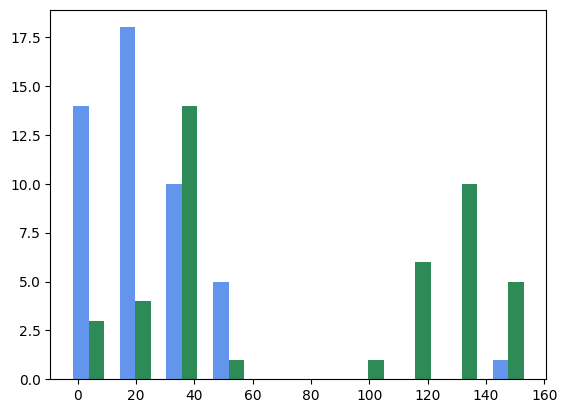

In [ ]:

# nullity if singular

# here we assume anything with a condition number >10^13 is singular
# blue = nullity in converging case
# green = nullity in non converging case

fig, ax = plt.subplots()

singular_nullity_converge = [
    computed_data['Q_size'][i] - computed_data['rank'][i]
    for i in computed_data[computed_data.cond_num > 10**13][computed_data.policy_converged == True].index
]

singular_nullity_non_converge = [
    computed_data['Q_size'][i] - computed_data['rank'][i]
    for i in computed_data[computed_data.cond_num > 10**13][computed_data.policy_converged == False].index
]

a_heights, a_bins = np.histogram(
    singular_nullity_converge
    , bins=10
)
b_heights, b_bins = np.histogram(
    singular_nullity_non_converge
    , bins=a_bins
    )

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')
#seaborn.despine(ax=ax, offset=10)

# plt.yscale('log')

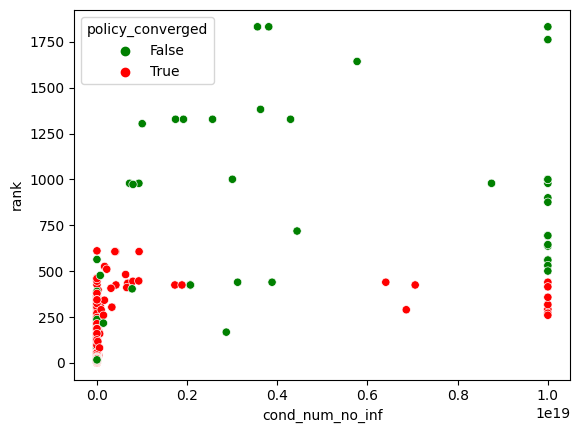

In [ ]:
splot = sns.scatterplot(
    data=computed_data,
    x=computed_data.cond_num_no_inf,
    y='rank',
    hue='policy_converged',
    palette=["green", "red"]
)

In [ ]:
computed_data[computed_data.policy_converged == False][computed_data.Q_size < 20]

/tmp/ipykernel_4875/150160030.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  computed_data[computed_data.policy_converged == False][computed_data.Q_size < 20]


,Q,policy_converged,f_name,Q_size,Q_inv,Q_inv_min_val,Q_inv_num_lt_0,eigenvalues,cond_num,Q_num_off_diag_entries,thetas,min_theta,cond_num_no_inf,rank
566,"[[0.0795775, 0.0397854, 0.000904145, 0.029129,...",False,outs/grid/itr_30.xml.out,19,"[[-63953134.570646696, 15529461.972691577, -17...",-6.395313e+07,185.0,"[0.273726242788801, 0.20253450404466772, 0.189...",7.635286e+07,164,"[0.7435033559072024, 88.6979195913279, 42.9379...",0.709431,7.635286e+07,19
614,"[[0.0795775, 0.0282941, 0.0397856, 0.0272815, ...",False,outs/grid/itr_78.xml.out,14,"[[-17778138.177868422, -320798.4049469917, 180...",-1.824015e+07,96.0,"[0.22764873861769502, 0.18127773877244271, 0.1...",1.193928e+07,80,"[44.674859890999294, 0.7209673948644532, 46.71...",0.697704,1.193928e+07,14
631,"[[0.0795775, 0.0346393, 0.0, 0.0, 0.0, 0.0, 0....",False,outs/grid/itr_95.xml.out,13,"[[17.68155964719577, -11.751228022065147, 2.61...",-3.134195e+07,86.0,"[0.2223621743575918, 0.16172568431307244, 0.13...",1.831418e+07,76,"[29.473861320238708, 29.473861320238708, 27.32...",1.380572,1.831418e+07,13
635,"[[0.0795775, 0.000429681, 0.0284597, 4.64954e-...",False,outs/grid/itr_99.xml.out,17,"[[41.1436305507469, 27.72241717220886, -26.786...",-7.990152e+07,144.0,"[0.2624926064215097, 0.20684313047807598, 0.14...",8.933527e+07,122,"[89.38124755439374, 44.334667366167466, 89.933...",0.203108,8.933527e+07,17


# what does the policy iteration do when it doesn't converge?
## output running the first frame of `itr_95.xml`
- iteration 1, distance to soln: 35.542
- iteration 2, distance to soln: 34.2647
- iteration 3, distance to soln: 35.2375
- iteration 4, distance to soln: 10.7552
- iteration 5, distance to soln: 35.2375
- iteration 6, distance to soln: 10.7552
- iteration 7, distance to soln: 35.2375
- iteration 8, distance to soln: 10.7552
- iteration 9, distance to soln: 35.2375
- iteration 10, distance to soln: 10.7552
- ...

## for `1000.xml`:
- iteration 0, distance to soln: nan
- iteration 1, distance to soln: 21.5797
- iteration 2, distance to soln: 9412.32
- iteration 3, distance to soln: 30.4784
- iteration 4, distance to soln: 359.357
- iteration 5, distance to soln: 8.70869
- iteration 6, distance to soln: 29.3738
- iteration 7, distance to soln: 106.393
- iteration 8, distance to soln: 142.2
- iteration 9, distance to soln: 965.884
- iteration 10, distance to soln: 12.2376
- iteration 11, distance to soln: 8.25851
- iteration 12, distance to soln: 80.6567
- iteration 13, distance to soln: 8.81398
- iteration 14, distance to soln: 9.2484
- iteration 15, distance to soln: 603.869
- iteration 16, distance to soln: 11.0963
- iteration 17, distance to soln: 9.76941
- iteration 18, distance to soln: 138.615
- iteration 19, distance to soln: 14.3429
- iteration 20, distance to soln: 7.08607
- iteration 21, distance to soln: 90.7551
- iteration 22, distance to soln: 61.3916
- iteration 23, distance to soln: 6.94709
- iteration 24, distance to soln: 95.927
- iteration 25, distance to soln: 12.211
- iteration 26, distance to soln: 35.1053
- iteration 27, distance to soln: 7.2344
- iteration 28, distance to soln: 13.354
- iteration 29, distance to soln: 108.095
- iteration 30, distance to soln: 10.8454
- iteration 31, distance to soln: 6.69158
- iteration 32, distance to soln: 31.3015
- iteration 33, distance to soln: 77.91
- iteration 34, distance to soln: 158.918
- iteration 35, distance to soln: 10.5831
- iteration 36, distance to soln: 6.76818
- iteration 37, distance to soln: 180.168
- iteration 38, distance to soln: 32.16
- iteration 39, distance to soln: 8.21768
- iteration 40, distance to soln: 110.953
- iteration 41, distance to soln: 9.56108
- iteration 42, distance to soln: 6.07339
- iteration 43, distance to soln: 188.909
- iteration 44, distance to soln: 427.162
- iteration 45, distance to soln: 6.79215
- iteration 46, distance to soln: 444.826
- iteration 47, distance to soln: 473.64
- iteration 48, distance to soln: 9.04461
- iteration 49, distance to soln: 99.1477
- iteration 50, distance to soln: 7.22687
- iteration 51, distance to soln: 6.83344
- iteration 52, distance to soln: 8.94199
- iteration 53, distance to soln: 66.2562
- iteration 54, distance to soln: 9.87378
- iteration 55, distance to soln: 7.00672
- iteration 56, distance to soln: 6.12515
- iteration 57, distance to soln: 6.35435
- iteration 58, distance to soln: 6.01478
- iteration 59, distance to soln: 6.01547
- iteration 60, distance to soln: 6.00704
- iteration 61, distance to soln: 5.99986
- iteration 62, distance to soln: 6.00401
- iteration 63, distance to soln: 5.99986
- iteration 64, distance to soln: 6.00401
- iteration 65, distance to soln: 5.99986
- iteration 66, distance to soln: 6.00401
- iteration 67, distance to soln: 5.99986
- iteration 68, distance to soln: 6.00401
- iteration 69, distance to soln: 5.99986
- iteration 70, distance to soln: 6.00401
- iteration 71, distance to soln: 5.99986
- iteration 72, distance to soln: 6.00401
- iteration 73, distance to soln: 5.99986
- iteration 74, distance to soln: 6.00401
- iteration 75, distance to soln: 5.99986
- iteration 76, distance to soln: 6.00401
- iteration 77, distance to soln: 5.99986
- iteration 78, distance to soln: 6.00401
- iteration 79, distance to soln: 5.99986
- iteration 80, distance to soln: 6.00401
- iteration 81, distance to soln: 5.99986
- iteration 82, distance to soln: 6.00401
- iteration 83, distance to soln: 5.99986
- iteration 84, distance to soln: 6.00401
- iteration 85, distance to soln: 5.99986
- iteration 86, distance to soln: 6.00401
- iteration 87, distance to soln: 5.99986
- iteration 88, distance to soln: 6.00401
- iteration 89, distance to soln: 5.99986
- iteration 90, distance to soln: 6.00401
- iteration 91, distance to soln: 5.99986
- iteration 92, distance to soln: 6.00401
- iteration 93, distance to soln: 5.99986
- iteration 94, distance to soln: 6.00401
- iteration 95, distance to soln: 5.99986
- iteration 96, distance to soln: 6.00401
- iteration 97, distance to soln: 5.99986
- iteration 98, distance to soln: 6.00401
- iteration 99, distance to soln: 5.99986
- iteration 100, distance to soln: 6.00401

In [ ]:
computed_data[computed_data.f_name == 'outs/grid/itr_95.xml.out']

,Q,policy_converged,f_name,Q_size,Q_inv,Q_inv_min_val,Q_inv_num_lt_0,eigenvalues,cond_num,Q_num_off_diag_entries,thetas,min_theta,cond_num_no_inf,rank
631,"[[0.0795775, 0.0346393, 0.0, 0.0, 0.0, 0.0, 0....",False,outs/grid/itr_95.xml.out,13,"[[17.68155964719577, -11.751228022065147, 2.61...",-3.134195e+07,86.0,"[0.2223621743575918, 0.16172568431307244, 0.13...",1.831418e+07,76,"[29.473861320238708, 29.473861320238708, 27.32...",1.380572,1.831418e+07,13


In [ ]:

print(computed_data[computed_data.f_name == 'outs/grid/itr_95.xml.out']['Q'].values[0])

[[ 0.0795775   0.0346393   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.0346393   0.0795775   0.0353494   0.          0.0363427   0.
   0.          0.          0.0235276   0.0124028  -0.0190503   0.
   0.        ]
 [ 0.          0.0353494   0.0795775  -0.00202077  0.0397227   0.
   0.          0.          0.0356312   0.0283727  -0.00089057  0.
   0.        ]
 [ 0.          0.         -0.00202077  0.0795775   0.          0.0304589
   0.          0.          0.0194945   0.          0.          0.00176185
   0.        ]
 [ 0.          0.0363427   0.0397227   0.          0.0795775  -0.0253923
   0.00332338  0.0294094   0.0345521   0.0267188  -0.00318035  0.
   0.        ]
 [ 0.          0.          0.          0.0304589  -0.0253923   0.0795775
   0.0284049   0.0018645   0.0372408   0.          0.          0.0269243
   0.        ]
 [ 0.          0.          0.          0.          0.00332338  0.0284049
   0.0795

In [ ]:
computed_data[computed_data.policy_converged == False]['Q_inv_min_val'].corr(computed_data[computed_data.policy_converged == False]['cond_num'])

-0.46805689072373696

/tmp/ipykernel_4875/3181339755.py:1: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  splot = sns.scatterplot(


[None]

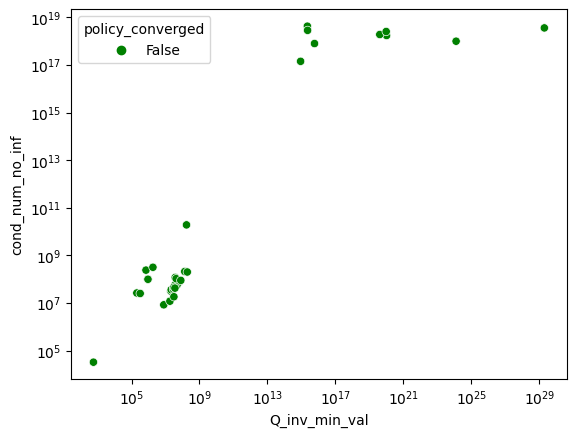

In [ ]:
splot = sns.scatterplot(
    data=computed_data[computed_data.policy_converged == False],
    x=computed_data[computed_data.policy_converged == False]['Q_inv_min_val'] * -1,
    y='cond_num_no_inf',
    hue='policy_converged',
    palette=["green", "red"]
)
splot.set(xscale = 'log')
splot.set(yscale = 'log')

- figure out a lambda so that the initial submatrix is singular
- look at the submatrix when PI in IS  converging (in K4 case)
    - WHY DOES IT CONVERGE??
- investigate the alternating case
    - ensure Q1 Q2 alternating
    - try to tie these sub-matricies to a physical interpretation
        - if not... step thru iteration, look at lambdas and manually compute next submatrices to understand why (algebraically)
            - probably something to do with the lambda values